# Compare seismics, infrasound and acoustic signals

In [1]:
import asdf
import numpy as np
import pandas as pd
from IPython.display import JSON
from scipy import signal as sig
from pathlib import Path

import matplotlib.pyplot as plt
import matplotlib
from matplotlib.patches import Patch, Rectangle
from matplotlib.lines import Line2D
import seaborn as sbn
%matplotlib inline
matplotlib.rc('text', usetex=True)
matplotlib.rc('font', size=12)

In [2]:
dataloc = Path('../data')

pltt = sbn.color_palette([
    '#2271B2', '#D55E00', '#359B73', '#E20134', '#A40122', '#000000'])
sbn.set_palette(pltt)
pltt

[(0.13333333333333333, 0.44313725490196076, 0.6980392156862745),
 (0.8352941176470589, 0.3686274509803922, 0.0),
 (0.20784313725490197, 0.6078431372549019, 0.45098039215686275),
 (0.8862745098039215, 0.00392156862745098, 0.20392156862745098),
 (0.6431372549019608, 0.00392156862745098, 0.13333333333333333),
 (0.0, 0.0, 0.0)]

## load data

In [3]:
import datarepo
from datarepo import xyz, xy, byu_chpmap, byu_pchmap, byu_ch
pos = datarepo.get_pos()
byu_mics = datarepo.get_byu_mics()
msumm = datarepo.get_byu_mics_summ()

af = asdf.open(dataloc / 'UCSB_seis_inf/asdf/seis_inf.asdf', mode='rw')
af.find_references()

In [4]:
# af['pad1']
af.info(40)

root (AsdfObject)
├─asdf_library (Software)
│ ├─author (str): Space Telescope Science Institute
│ ├─homepage (str): http://github.com/spacetelescope/asdf
│ ├─name (str): asdf
│ └─version (str): 2.7.1
├─history (dict)
│ └─extensions (list)
│   └─[0] (ExtensionMetadata) ...
├─comment (dict)
│ └─anl/ucsb_seis_inf_to_asdf.ipynb (dict)
│   ├─note (str): asdf data from "raw" UCSB MINISEED.
  - Raw data is cropped to 20 s window (truncated)
│   └─run_after (list) ...
├─pad1 (dict)
│ ├─ascii_off (float): 1.8025
│ ├─inf (dict)
│ │ ├─1 (dict) ...
│ │ ├─2 (dict) ...
│ │ └─3 (dict) ...
│ ├─seis (dict)
│ │ ├─1 (dict) ...
│ │ ├─2 (dict) ...
│ │ └─5 not shown
│ └─t (Reference)
├─pad2 (dict)
│ ├─ascii_off (float): 3.425
│ ├─inf (dict) ...
│ ├─seis (dict) ...
│ └─t (Reference)
├─pad3 (dict)
│ ├─ascii_off (float): 6.985
│ ├─inf (dict) ...
│ ├─seis (dict) ...
│ └─t (Reference)
└─pad4 (dict)
  ├─ascii_off (float): 2.6825
  ├─inf (dict) ...
  ├─seis (dict) ...
  └─t (Reference)
Some nodes not shown.


Summary table for seismics

In [5]:
ssumm = pd.DataFrame(
    data=np.nan, index=pd.RangeIndex(4 * 6 * 2),
    columns=['pad', 'blast', 'ch', 'vmax', 'tmax', 'vmin', 'tmin']
)
ssumm.head(1)

pad  blast  ch  vmax  tmax  vmin  tmin
0  NaN    NaN NaN   NaN   NaN   NaN   NaN

Summary table for infrasound

In [6]:
isumm = pd.DataFrame(
    data=np.nan, index=pd.RangeIndex(4 * 6 * 9),
    columns=['pad', 'blast', 'ch', 'pmax', 'tmax', 'pmin', 'tmin']
)
isumm.head(1)

pad  blast  ch  pmax  tmax  pmin  tmin
0  NaN    NaN NaN   NaN   NaN   NaN   NaN

In [7]:
.5 * msumm.ppf46 ** 2 * (msumm.t1 - msumm.ts) * msumm.m2

0           NaN
1           NaN
2           NaN
3           NaN
4           NaN
         ...   
607    0.037824
608    0.015407
609    0.141835
610    0.054653
611    0.182057
Length: 612, dtype: float64

- `srate`: sampling rate of sismics/inf
- `msrate`: sampling rate of acoustics

In [8]:
srate = 400.
msrate = 204800.

infch = {1: [1, 2, 3], 2: [1, 2, 3], 3: [1, 2, 3]}
seisch = {i: ['hhe', 'hhn', 'hhz'] for i in range(1, 8)}

## Helper Funcs

### `make_entries()`

In [9]:
scurrl, icurrl = 0, 0

def make_entries(dta, pad, ch, intvs, typ='seis'):
    global scurrl, icurrl
    for blast, intv in enumerate(intvs):
        start, end = int(srate * intv[0]), int(srate * intv[1])
        vmax = dta[typ][start:end].max()
        tmax = (dta[start:end].argmax() + start) / srate
        vmin = dta[start:end].min()
        tmin = (dta[start:end].argmin() + start) / srate
        if typ == 'seis':
            ssumm.loc[scurrl] = [pad, blast + 1, float(ch), vmax, tmax, vmin, tmin]
            scurrl += 1
        else:
            isumm.loc[icurrl] = [pad, blast + 1, float(ch), vmax, tmax, vmin, tmin]
            icurrl += 1

### `plot_seis()`

In [10]:
def plot_seis(t, seis, start: float = 0., end: float = 10.):
    fig, axs = plt.subplots(nrows=7, sharex=True)
    srate = (len(t) - 1) / (t[-1] - t[0])
    start, end = int(start * srate), int(end * srate)
    for station, ax in zip(range(1, 8), axs):
        ax.plot(t[start:end],
                sig.detrend(seis[station]['hhn'][start:end], type='constant'))
        ax.plot(t[start:end],
                sig.detrend(seis[station]['hhz'][start:end], type='constant'))
    axs[-1].set_xlabel(r'$t\ /\ \mathrm{s}$')
    fig.set_size_inches(8, 10)
    fig.subplots_adjust(left=.05, right=.99, bottom=.05, top=.98)
    return fig, axs

### `norm()`

Normalize an array to it's maximum

In [11]:
def norm(data):
    return data / np.sqrt(np.trapz(data ** 2, axis=0) / len(data))

In [12]:
pos.loc[122:]

label  h_off   r   ϕ   θ  x_raw  y_raw  z_raw          x  \
point                                                                  
122         NYS01    NaN NaN NaN NaN    NaN    NaN    NaN  28.608807   
123         NYS02    NaN NaN NaN NaN    NaN    NaN    NaN  24.301585   
124         NYS03    NaN NaN NaN NaN    NaN    NaN    NaN  25.210863   
125         NYS04    NaN NaN NaN NaN    NaN    NaN    NaN  26.120449   
126         NYS05    NaN NaN NaN NaN    NaN    NaN    NaN  19.772250   
127         NYS06    NaN NaN NaN NaN    NaN    NaN    NaN  20.682395   
128         NYS07    NaN NaN NaN NaN    NaN    NaN    NaN  26.808858   
129         NYI11    NaN NaN NaN NaN    NaN    NaN    NaN  44.257375   
130         NYI12    NaN NaN NaN NaN    NaN    NaN    NaN  28.608807   
131         NYI13    NaN NaN NaN NaN    NaN    NaN    NaN  -7.680367   
132         NYI21    NaN NaN NaN NaN    NaN    NaN    NaN  24.301585   
133         NYI22    NaN NaN NaN NaN    NaN    NaN    NaN  25.210863   
134         NYI23    NaN NaN NaN NaN    NaN    NaN    NaN  26.120449   
135         NYI31    NaN NaN NaN NaN    NaN    NaN    NaN  19.772250   
136         NYI32    NaN NaN NaN NaN    NaN    NaN    NaN  20.682395   
137         NYI33    NaN NaN NaN NaN    NaN    NaN    NaN  26.808858   
138      geophone    NaN NaN NaN NaN    NaN    NaN    NaN  26.348397   
139           gp1    NaN NaN NaN NaN    NaN    NaN    NaN  26.348397   
140           gp2    NaN NaN NaN NaN    NaN    NaN    NaN  26.243016   
141           gp3    NaN NaN NaN NaN    NaN    NaN    NaN  26.135091   
142           gp4    NaN NaN NaN NaN    NaN    NaN    NaN  26.223879   
143           gp5    NaN NaN NaN NaN    NaN    NaN    NaN  26.093814   
144           gp6    NaN NaN NaN NaN    NaN    NaN    NaN  26.055083   
145           gp7    NaN NaN NaN NaN    NaN    NaN    NaN  26.121732   
146           gp8    NaN NaN NaN NaN    NaN    NaN    NaN  25.955024   
147           gp9    NaN NaN NaN NaN    NaN    NaN    NaN  26.016581   
148          gp10    NaN NaN NaN NaN    NaN    NaN    NaN  25.911201   
149          gp11    NaN NaN NaN NaN    NaN    NaN    NaN  25.847556   
150          gp12    NaN NaN NaN NaN    NaN    NaN    NaN  25.872470   
151          gp13    NaN NaN NaN NaN    NaN    NaN    NaN  25.831194   
152          gp14    NaN NaN NaN NaN    NaN    NaN    NaN  25.841552   
153          gp15    NaN NaN NaN NaN    NaN    NaN    NaN  25.798812   
154          gp16    NaN NaN NaN NaN    NaN    NaN    NaN  25.723970   
155          gp17    NaN NaN NaN NaN    NaN    NaN    NaN  25.796392   
156          gp18    NaN NaN NaN NaN    NaN    NaN    NaN  25.533260   
157          gp19    NaN NaN NaN NaN    NaN    NaN    NaN  25.487209   
158          gp20    NaN NaN NaN NaN    NaN    NaN    NaN  25.429122   
159          gp21    NaN NaN NaN NaN    NaN    NaN    NaN  25.213438   
160          gp22    NaN NaN NaN NaN    NaN    NaN    NaN  25.362299   
161          gp23    NaN NaN NaN NaN    NaN    NaN    NaN  25.173353   
162    broadbands    NaN NaN NaN NaN    NaN    NaN    NaN  49.316993   
163      acoustic    NaN NaN NaN NaN    NaN    NaN    NaN  26.182603   

                y       z        latn_m         lone_m        ht   latn_deg  \
point                                                                         
122     27.665186 -0.7798  4.708161e+06  695992.783169  403.8817 -78.614700   
123    -32.956018 -3.0374  4.708106e+06  696018.997279  401.6241 -78.614400   
124    -83.768950 -1.7690  4.708063e+06  696044.899179  402.8925 -78.614100   
125   -134.581957  2.8392  4.708019e+06  696070.801385  407.5007 -78.613800   
126   -181.535218  2.1016  4.707975e+06  696088.486559  406.7631 -78.613600   
127   -232.348372  0.5769  4.707931e+06  696114.389323  405.2384 -78.613300   
128   -273.353153 -1.7344  4.707899e+06  696139.979669  402.9271 -78.613000   
129     57.090228 -1.4825  4.708195e+06  695991.845620  403.1790 -78.614700   
130     27.665186 -0.7798  4.708161e+06  695992.78316

## `posmap`

Line numbers of pad- and sensor locations in the `pos` table:

In [13]:
posmap = {
    'pad': {1: [6, 7, 8], 2: [10, 11, 12], 3: [13, 14, 15], 4: [17, 18, 19]},
    'inf': {1: {1: 129, 2: 130, 3: 131}, 2: {1: 132, 2: 133, 3: 134},
            3: {1: 135, 2: 136, 3: 137}},
    'seis': {1: 122, 2: 123, 3: 124, 4: 125, 5: 126, 6: 127, 7: 128}
}

In [14]:
cm = {'n': '#050505', 'z': '#5575b5', 'e': '#b57575',
      'a': '#a55555', 'i': '#55a555'}

In [15]:
pos.loc[122]

label                NYS01
h_off                  NaN
r                      NaN
ϕ                      NaN
θ                      NaN
x_raw                  NaN
y_raw                  NaN
z_raw                  NaN
x                28.608807
y                27.665186
z                  -0.7798
latn_m      4708161.227069
lone_m       695992.783169
ht                403.8817
latn_deg          -78.6147
lone_deg            42.501
Name: 122, dtype: object

## `highpass()`

Remove some offsets from signals

In [16]:
def highpass(data, freq: float = 1., srate: float = srate, half_ord: int = 2):
    freq = freq / (.5 * srate)
    b, a = sig.butter(half_ord, freq, btype='highpass', analog=False, output='ba')
    return sig.filtfilt(b, a, data)

## Plotting

### `r_plot()`

In [17]:
fhp = .5
default_filtpars = dict(freq=fhp, order=4)

def r_plot(r, t, data, amp, ax, clr, 
           plotlbls=None, showch=False, chlbls=None, filt=None):
    ln = data.shape[1]
    if not isinstance(clr, list):
        clr = ln * [clr]
    opts = dict(color=clr[0], lw=.5)
    ax.set_xlim(t[0], t[-1])
    ax.set_yticks([0, 30, 80, 130, 180, 230, 280, 330])
    for i in range(ln):
        if showch:
            xlim = ax.get_xlim()
            ax.text(xlim[0] + .025 * (xlim[0] + xlim[1]), r[i] + 3,
                    s=chlbls[i], color=clr[i], fontsize=10, va='bottom')
            if plotlbls is not None:
                opts = opts.copy()
                opts.update(label=plotlbls[i], color=clr[i])
        if filt is None:
            y = sig.detrend(data[:, i], type='constant')
        else:
            if filt is True:
                filt = default_filtpars
            y = highpass(data[:, i], filt['freq'], filt['order'] // 2)
        ax.plot(t, amp * norm(y) + r[i], **opts)
    ax.set_ylim(0, 380)

### `add_char_label()`

In [18]:
def add_char_label(lbl, ax, txtclr='white', bc='#a5a5a5'):
    try:
        dpi = ax.figure.get_dpi()
    except AttributeError:
        dpi = ax.figure.figure.get_dpi()
    pnts = ax.transAxes.transform([(0, 0), (1, 1)])
    sfx = dpi / (72 * (pnts[1, 0] - pnts[0, 0]))
    sfy = dpi / (72 * (pnts[1, 1] - pnts[0, 1]))
    ax.add_artist(plt.Rectangle(
        (-50 * sfx, 1. - 15 * sfy), 11 * sfx, 15 * sfy,
        transform=ax.transAxes, ec='none', fc=bc, clip_on=False
    ))
    ax.text(-45 * sfx, 1 - 8 * sfy, lbl, ha='center', va='center',
            transform=ax.transAxes, color=txtclr)

## `plot01()`

Plot seismic stations and infrasound

In [19]:
infch

{1: [1, 2, 3], 2: [1, 2, 3], 3: [1, 2, 3]}

In [20]:
pos.loc[129:137]

label  h_off   r   ϕ   θ  x_raw  y_raw  z_raw          x           y  \
point                                                                         
129    NYI11    NaN NaN NaN NaN    NaN    NaN    NaN  44.257375   57.090228   
130    NYI12    NaN NaN NaN NaN    NaN    NaN    NaN  28.608807   27.665186   
131    NYI13    NaN NaN NaN NaN    NaN    NaN    NaN  -7.680367   46.964317   
132    NYI21    NaN NaN NaN NaN    NaN    NaN    NaN  24.301585  -32.956018   
133    NYI22    NaN NaN NaN NaN    NaN    NaN    NaN  25.210863  -83.768950   
134    NYI23    NaN NaN NaN NaN    NaN    NaN    NaN  26.120449 -134.581957   
135    NYI31    NaN NaN NaN NaN    NaN    NaN    NaN  19.772250 -181.535218   
136    NYI32    NaN NaN NaN NaN    NaN    NaN    NaN  20.682395 -232.348372   
137    NYI33    NaN NaN NaN NaN    NaN    NaN    NaN  26.808858 -273.353153   

            z        latn_m         lone_m        ht  latn_deg  lone_deg  
point                                                                     
129   -1.4825  4.708195e+06  695991.845620  403.1790  -78.6147   42.5013  
130   -0.7798  4.708161e+06  695992.783169  403.8817  -78.6147   42.5010  
131   -7.2449  4.708160e+06  695951.697601  397.4166  -78.6152   42.5010  
132   -3.0374  4.708106e+06  696018.997279  401.6241  -78.6144   42.5005  
133   -1.7690  4.708063e+06  696044.899179  402.8925  -78.6141   42.5001  
134    2.8392  4.708019e+06  696070.801385  407.5007  -78.6138   42.4997  
135    2.1016  4.707975e+06  696088.486559  406.7631  -78.6136   42.4993  
136    0.5769  4.707931e+06  696114.389323  405.2384  -78.6133   42.4989  
137   -1.7344  4.707899e+06  696139.979669  402.9271  -78.6130   42.4986

In [21]:
posmap

{'pad': {1: [6, 7, 8], 2: [10, 11, 12], 3: [13, 14, 15], 4: [17, 18, 19]},
 'inf': {1: {1: 129, 2: 130, 3: 131},
  2: {1: 132, 2: 133, 3: 134},
  3: {1: 135, 2: 136, 3: 137}},
 'seis': {1: 122, 2: 123, 3: 124, 4: 125, 5: 126, 6: 127, 7: 128}}

In [22]:
np.sum(
    np.sqrt(
        (pos.loc[posmap['pad'][2], xyz].sum(axis=0) / 3 - pos.loc[129:137, xyz]) ** 2
    ),
    axis=1
)

point
129     29.832103
130     31.187822
131     38.450950
132     88.811004
133    139.264813
134    194.565606
135    236.862568
136    285.240877
137    330.412411
dtype: float64

In [23]:
amp = 330 / 15
ampi = 1.5 * 330 / 14
vmodes = ['e', 'n', 'z']
vtrans = {'e': 't', 'n': 'r', 'z': 'z'}
def plot01(ssin, mcs, start=0., end=5., pad=1,
           vel='nz', prch=infch, mch=byu_ch['rline']['h'],
           nlab=False, ext_layout=False, showch=False):
    keys = list(vel)
    if ext_layout:
        fig = plt.figure()
        ax1 = plt.subplot2grid((6, 3), (0, 0), rowspan=2, colspan=2, fig=fig)
        ax2 = plt.subplot2grid((6, 3), (2, 0), rowspan=2, colspan=2, fig=fig)
        ax3 = plt.subplot2grid((6, 3), (4, 0), rowspan=2, colspan=2, fig=fig)
        ax4 = plt.subplot2grid((6, 3), (0, 2), rowspan=2, colspan=1, fig=fig)
        ax5 = plt.subplot2grid((6, 3), (3, 2), rowspan=3, colspan=1, fig=fig)
        axs = (ax1, ax2, ax3, ax4, ax5)
    else:
        fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, sharex=True)
        axs = (ax1, ax2, ax3)
    for ax in (ax1, ax2, ax3):
        ax.set_xlim(start, end)
    if ext_layout:
        for ax in (ax1, ax2):
            ax.set_xticklabels([])
    toff = ssin['ascii_off']
    t, inf, seis = ssin['t'][:] - toff, ssin['inf'], ssin['seis']
    mstart, mend = int(msrate * start), int(msrate * end)
    start, end = int(srate * (start + toff)), int(srate * (end + toff))
    center = pos.loc[posmap['pad'][pad], xyz].values.sum(axis=0) / 3
    # rs = [np.sqrt(np.sum((center - pos.loc[122, xyz].values) ** 2))]
    rs = []
    data = np.empty((end - start, sum(len(v) for v in prch.values())))
    k, lbls, plotlabels = 0, [], []
    for i, js in prch.items():
        for j in js:
            idx = posmap['inf'][i][j]
            r = np.sqrt(np.sum((center - pos.loc[idx, xyz].values) ** 2))
            rs.append(r)
            data[:, k] = inf[i][j][start:end]
            k += 1
            lbls.append(f'{i}.{j}')
            plotlabels.append(f'NYS{i}.{j}')
    pt = t[start:end]
    lbls = lbls if len(lbls) > 0 else False
    r_plot(rs, pt, data, ampi, ax2, '#459545', plotlabels, showch, lbls, True)
    rs, clrs, plotlabels, lbls = [], [], [], []
    data = np.empty((end - start, len(keys) * 7))
    for i in range(1, 8):
        r = np.sqrt(np.sum((center - pos.loc[posmap['seis'][i], xyz]) ** 2))
        rs.append(r)
        for key in keys:
            assert key in vmodes, f"Got invalid seismics component '{key}'."
            clr = cm[key] if len(keys) > 1 else '#e54545'
            clrs.append(clr)
            data[:, i - 1] = seis[i][f'hh{key}'][start:end]
            plotlabels.append(f'0{i}'); lbls.append(f'0{i}')
    r_plot(rs, pt, data, amp, ax1, clrs, plotlabels, True, lbls)
    data = np.empty((mend - mstart, len(mch)))
    rs, plotlabels, lbls = [], [], []
    for i, ch in enumerate(mch):
        if ch not in mcs.keys():
            print('ch: skipping mic channel %d' % ch)
            continue
        r = msumm.query('pad == %d & ch == %d' % (pad, ch)).loc[:, 'r']
        try:
            r = r.iloc[0]
        except IndexError:
            print('r: skipping mic channel %d' % ch)
            continue
        rs.append(r)
        data[:, i] = mcs[ch]['x'][mstart:mend]
        plotlabels.append(f'ch {ch}'); lbls.append(f'ch {ch}')
    mt = mcs[ch]['t'][mstart:mend]
    r_plot(rs, mt, data, ampi, ax3, '#4545e5', plotlabels, True, lbls)
    ax3.set_xlabel(r'$t\ /\ \mathrm{s}$')
    comps = [vtrans[k] for k in keys]
    ax1.text(.98, .98, 'seismic: %s' % (', '.join(comps)), ha='right', va='top',
             transform=ax1.transAxes)
    ax2.text(.98, .98, 'infrasound', ha='right', va='top', transform=ax2.transAxes)
    ax3.text(.98, .98, 'acoustic', ha='right', va='top', transform=ax3.transAxes)
    for ax in (ax1, ax2, ax3):
        ax.set_ylabel(r'$r\ /\ \mathrm{m}$')
        ax.set_ylim(0, 380)
        ax.set_yticks([0, 30, 80, 130, 180, 230, 280, 330])
    if nlab:
        for lab, ax in zip('abcde'[:len(axs)], axs):
            add_char_label(lab, ax)
    fig.subplots_adjust(top=0.93, bottom=0.08, left=0.1, right=0.97, hspace=0.08)
    fig.set_size_inches(8, 9)
    return fig, axs

# Seismics

## Pad 1

In [24]:
seis = af['pad1']['seis']
seis

{1: {'hhe': <Reference (unloaded) to 'ucsb_seis_pad1_NYS01_hhe.asdf#v'>,
  'hhn': <Reference (unloaded) to 'ucsb_seis_pad1_NYS01_hhn.asdf#v'>,
  'hhz': <Reference (unloaded) to 'ucsb_seis_pad1_NYS01_hhz.asdf#v'>},
 2: {'hhe': <Reference (unloaded) to 'ucsb_seis_pad1_NYS02_hhe.asdf#v'>,
  'hhn': <Reference (unloaded) to 'ucsb_seis_pad1_NYS02_hhn.asdf#v'>,
  'hhz': <Reference (unloaded) to 'ucsb_seis_pad1_NYS02_hhz.asdf#v'>},
 3: {'hhe': <Reference (unloaded) to 'ucsb_seis_pad1_NYS03_hhe.asdf#v'>,
  'hhn': <Reference (unloaded) to 'ucsb_seis_pad1_NYS03_hhn.asdf#v'>,
  'hhz': <Reference (unloaded) to 'ucsb_seis_pad1_NYS03_hhz.asdf#v'>},
 4: {'hhe': <Reference (unloaded) to 'ucsb_seis_pad1_NYS04_hhe.asdf#v'>,
  'hhn': <Reference (unloaded) to 'ucsb_seis_pad1_NYS04_hhn.asdf#v'>,
  'hhz': <Reference (unloaded) to 'ucsb_seis_pad1_NYS04_hhz.asdf#v'>},
 5: {'hhe': <Reference (unloaded) to 'ucsb_seis_pad1_NYS05_hhe.asdf#v'>,
  'hhn': <Reference (unloaded) to 'ucsb_seis_pad1_NYS05_hhn.asdf#v'>,
 

In [25]:
t = af['pad1']['t'][:] - af['pad1']['ascii_off']
srate = (t.shape[0] - 1) / (t[-1] - t[0])
srate

400.0

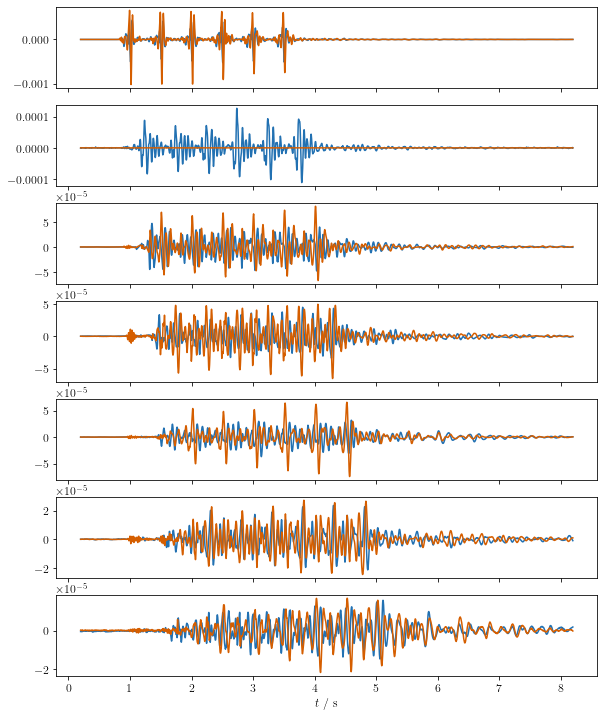

In [26]:
fig, axs = plot_seis(t, seis, start=2.)
# fig

## Pad 2

In [27]:
seis = af['pad2']['seis']
t = af['pad2']['t'][:] - af['pad2']['ascii_off']

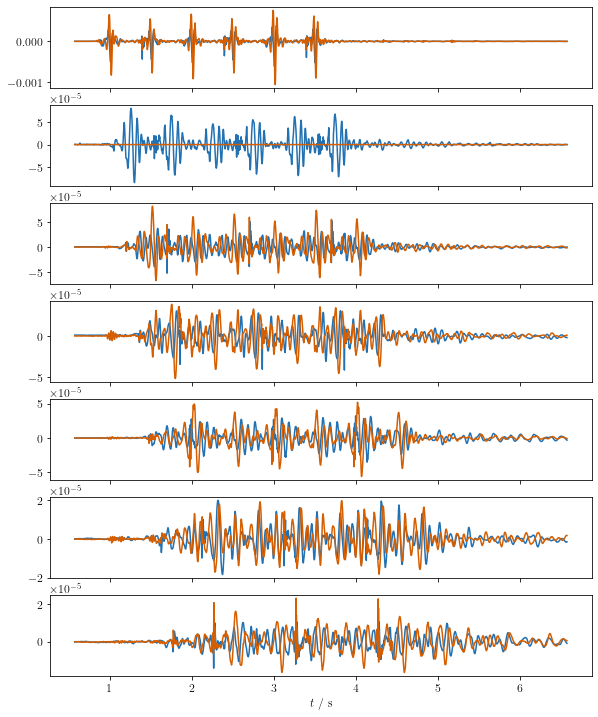

In [28]:
fig, axs = plot_seis(t, seis, start=4)
# fig

## Pad 3

In [29]:
seis = af['pad3']['seis']
t = af['pad3']['t'][:] - af['pad3']['ascii_off']

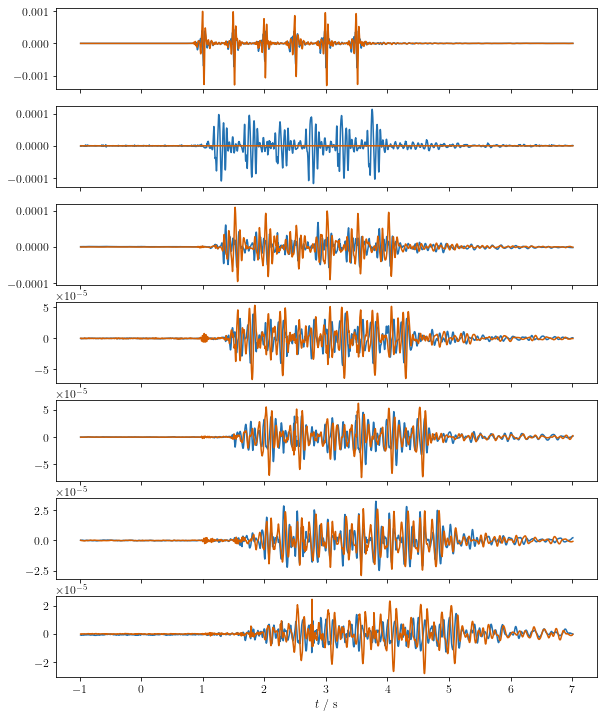

In [30]:
fig, axs = plot_seis(t, seis, start=6, end=14)
# fig

## Pad 4

In [31]:
seis = af['pad4']['seis']
t = af['pad4']['t'][:] - af['pad4']['ascii_off']

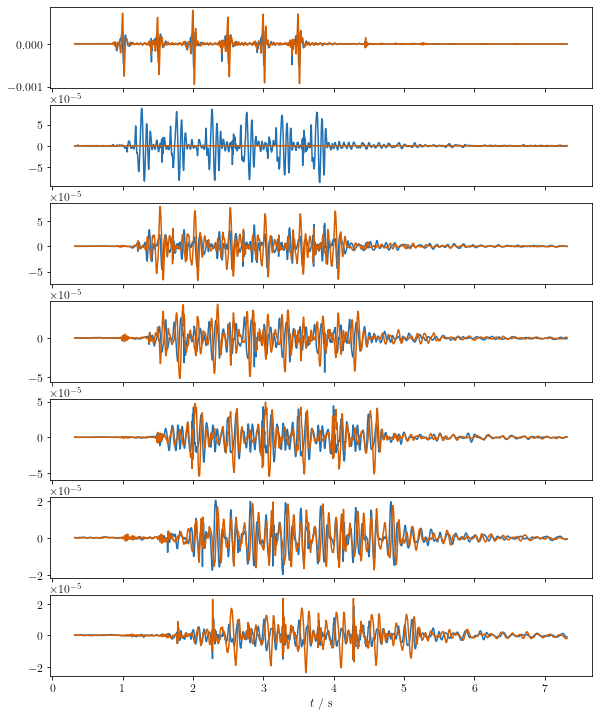

In [32]:
fig, axs = plot_seis(t, seis, start=3)
# fig

# Seismics + Infrasound

In [33]:
ich = infch.copy()
ich[1] = [2]
ich

{1: [2], 2: [1, 2, 3], 3: [1, 2, 3]}

## NYS01 + INF

### Pad 1

In [34]:
ssin = af['pad1']
pad = 1

In [35]:
icurrl, scurrl = 0, 0

In [36]:
intvs = np.array([[2.5 + i / 2, 3. + i / 2] for i in range(6)])
intvs

array([[2.5, 3. ],
       [3. , 3.5],
       [3.5, 4. ],
       [4. , 4.5],
       [4.5, 5. ],
       [5. , 5.5]])

In [37]:
posmap['inf']

{1: {1: 129, 2: 130, 3: 131},
 2: {1: 132, 2: 133, 3: 134},
 3: {1: 135, 2: 136, 3: 137}}

In [38]:
ssin['seis'][1]['hhz']

<Reference to array([0.0002002 , 0.00020014, 0.00020003, ..., 0.00019954, 0.00019947,
       0.00019943])>

In [39]:
byu_mics['pad1'].keys()

dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29])

In [40]:
byu_ch['rline']['h']

array([ 7, 22, 17, 19, 21, 25, 27, 29])

In [41]:
byu_ch['rline']['l']

array([ 6, 15, 14, 16, 18, 20, 24, 26, 28])

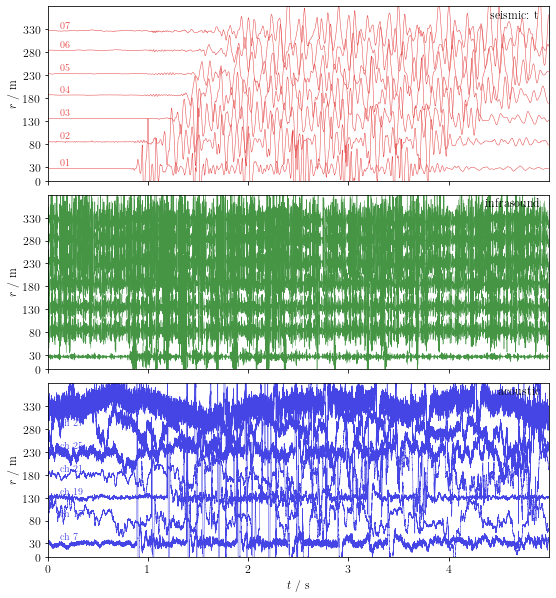

In [42]:
fig, ax = plot01(
    ssin, byu_mics['pad1'], start=0, end=5, pad=1,
    vel='e', prch=ich, mch=[ 7, 17, 19, 21, 25, 27, 28]
)
# fig

### Pad 2

In [43]:
ssin = af['pad2']

In [44]:
byu_ch['rline']['h']

array([ 7, 22, 17, 19, 21, 25, 27, 29])

In [45]:
byu_ch['rline']['l']

array([ 6, 15, 14, 16, 18, 20, 24, 26, 28])

Text(0.5, 0.98, 'Pad 2')

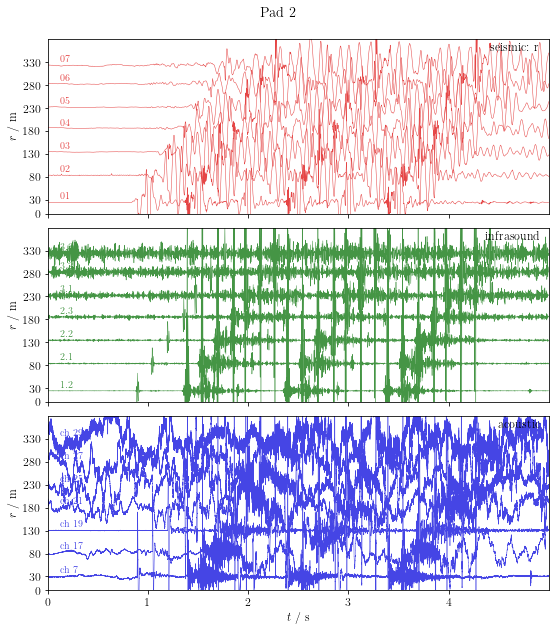

In [46]:
fig, axs = plot01(ssin, byu_mics['pad2'], 0., 5., pad=2, vel='n',
                  prch=ich, mch=[7, 17, 19, 21, 25, 27, 29], showch=True)
fig.suptitle("Pad 2")
# fig

In [47]:
plt.close('all')

In [48]:
ts, t1, pmax, tmax = msumm.loc[241, ['ts', 't1', 'pmax', 'tmax']]

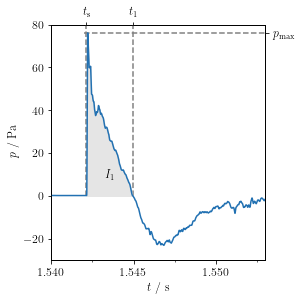

In [49]:
fig, ax = plt.subplots()
fig.set_size_inches(4, 4)
axa, axb = ax.twinx(), ax.twiny()
mics = byu_mics['pad2']

start, end = 1.54, 1.553
ax.set_xlim(start, end); ax.set_ylim(-30, 80)
axb.set_xlim(start, end); axa.set_ylim(-30, 80)
start, end = int(msrate * start), int(msrate * end)
mic17 = mics[17]['x'][start:end]
mt = mics[17]['t'][start:end]
axb.plot(mt, mic17, color=pltt[0], zorder=1)
axa.hlines([pmax], tmax, axa.get_xlim()[1],
            ls='dashed', color='gray', zorder=-1)
axb.vlines([ts, t1], 0, 80,
            color='gray', ls='dashed', label='test', zorder=-1)
axa.set_xticks([1.54, 1.545, 1.55])
axa.set_xticks([1.5425, 1.5475, 1.5525], minor=True);
axb.set_xticks([ts, t1])
axb.set_xticklabels([r'$t_\mathrm{s}$', r'$t_1$'])
axa.set_yticks([pmax])
axa.set_yticklabels([r'$p_\mathrm{max}$'])
axb.fill_between(mt, mic17, where=np.logical_and(mt >= ts, mt <= t1),
                 color='#e5e5e5', zorder=-1)
axb.text(.5 * (ts + t1), 10, s=r'$I_1$', va='center', ha='center')
ax.set_xlabel(r'$t\ /\ \mathrm{s}$')
ax.set_ylabel(r'$p\ /\ \mathrm{Pa}$')
fig.tight_layout(pad=0.05)

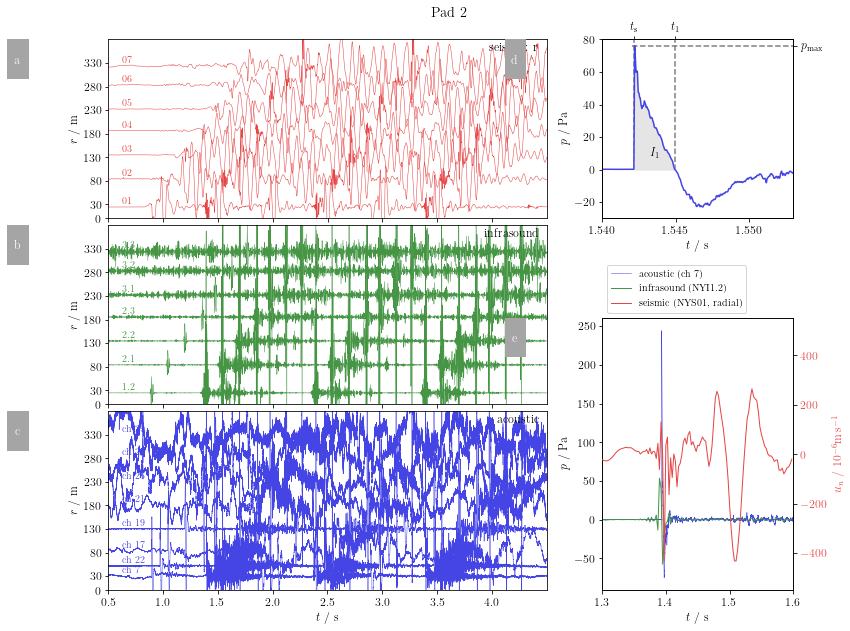

In [50]:
fig, axs = plot01(
    ssin, byu_mics['pad2'], start=0.5, end=4.5, pad=2,
    vel='n', prch=ich, mch=[7, 22, 17, 19, 21, 25, 27, 29],
    nlab=True, ext_layout=True, showch=True)
fig.suptitle('Pad 2')

ax4, ax5 = axs[-2:]
ax4a = ax4.twinx()
ax4b = ax4.twiny()
# ax4.set_zorder(1); ax4a.set_zorder(-1); ax4b.set_zorder(-1)
ax5a = ax5.twinx()
ax5.set_zorder(0); ax5a.set_zorder(1)

mics = byu_mics['pad2']

start, end = 1.54, 1.553
ax4.set_xlim(start, end); ax4.set_ylim(-30, 80)
ax4b.set_xlim(start, end); ax4a.set_ylim(-30, 80)
start, end = int(msrate * start), int(msrate * end)
mic17 = mics[17]['x'][start:end]
mt = mics[17]['t'][start:end]
ax4b.plot(mt, mic17, color='#4545e5', zorder=1)
ax4a.hlines([pmax], tmax, ax4a.get_xlim()[1],
            ls='dashed', color='gray', zorder=-1)
ax4b.vlines([ts, t1], 0, 80,
            color='gray', ls='dashed', label='test', zorder=-1)
ax4b.set_xticks([ts, t1])
ax4b.set_xticklabels([r'$t_\mathrm{s}$', r'$t_1$'])
ax4a.set_yticks([pmax])
ax4a.set_yticklabels([r'$p_\mathrm{max}$'])
ax4b.fill_between(mt, mic17, where=np.logical_and(mt >= ts, mt <= t1),
                 color='#e5e5e5', zorder=-1)
ax4b.text(.5 * (ts + t1), 10, s=r'$I_1$', va='center', ha='center')
ax4.set_xlabel(r'$t\ /\ \mathrm{s}$')
ax4.set_ylabel(r'$p\ /\ \mathrm{Pa}$')

start, end = 1.3, 1.6
start, end = int(msrate * start), int(msrate * end)
mic17 = mics[17]['x'][start:end]
mic7 = mics[7]['x'][start:end]
mt = mics[17]['t'][start:end]

ax5.plot(mt, sig.detrend(mic7, type='constant'), lw=.5, color='#4545e5',
         label='acoustic (ch 7)', zorder=1)

toff = ssin['ascii_off']
start, end = 1.3, 1.6
ax5.set_xlim(start, end)
start, end = int(srate * (toff + start)), int(srate * (toff + end))
t = ssin['t'][start:end] - toff
inf21 = ssin['inf'][2][1][start:end]
inf12 = ssin['inf'][1][2][start:end]
seis2n = ssin['seis'][2]['hhn'][start:end]
seis1n = ssin['seis'][1]['hhn'][start:end]

ax5.plot(t, sig.detrend(inf12, type='constant'), zorder=2,
         color='#459545', lw=1, label='infrasound (NYI1.2)')
ax5.plot([], [], color='#e54545', lw=1, label='seismic (NYS01, radial)')
ax5a.plot(t, sig.detrend(seis1n, type='constant') * 1e6, zorder=3,
          color='#e54545', lw=1, label='seismic (NYS01, radial)')
[lbl.set_color('#e54545') for lbl in ax5a.get_yticklabels()]
ax5.set_xlabel(r'$t\ /\ \mathrm{s}$')
ax5.set_ylabel(r'$p\ /\ \mathrm{Pa}$')
ax5a.set_ylabel(r'$u_n\ /\ 10^{-6}\mathrm{m\,s^{-1}}$', color='#e54545')
ax5a.set_ylim(-550, 550)
ax5.legend(loc='lower left', fontsize=10, bbox_to_anchor=(0, 1.0),
           bbox_transform=ax5.transAxes)
fig.subplots_adjust(top=0.93, bottom=0.08, left=0.07, right=0.935,
                    hspace=0.08, wspace=0.29)
fig.set_size_inches(11, 9)
# fig

In [51]:
fig, (ax1, ax2) = plt.subplots(ncols=2)
fig.set_size_inches(12, 4)

# start, end = 0.98, 1.04
start, end = 0.9, 1.05
start, end = int(srate * (toff + start)), int(srate * (toff + end))
hhz, hhn = ssin['seis'][1]['hhz'][start:end], ssin['seis'][1]['hhn'][start:end]

ax1.set_aspect(1)
ax1.plot(hhn * 1e3, hhz * 1e3, lw=.5)
ax1.plot(hhn * 1e3, hhz * 1e3, '.', ms=5, color='k')

ax2.plot(ssin['t'][start:end], hhn * 1e3, label=r'$v_r$')
ax2.plot(ssin['t'][start:end], hhz * 1e3, label=r'$v_z$')
ax2.legend(loc='lower left')
ax1.set_ylim(-.7, .9)
ax1.set_xlabel(r'$v_r\ /\ 10^{-3}\mathrm{ms^{-1}}$')
ax1.set_ylabel(r'$v_z\ /\ 10^{-3}\mathrm{ms^{-1}}$');

In [52]:
def mkfig():
    fig = plt.figure(figsize=(11, 13))
    sfs = fig.subfigures(nrows=2, ncols=1, height_ratios=[2, 1])
    fig.subplots_adjust(hspace=0)
    sf1, sf2 = sfs[0].subfigures(nrows=1, ncols=2, width_ratios=[2, 1])
    ax11, ax12, ax13 = sf1.subplots(nrows=3)
    sf3, sf4 = sfs[1].subfigures(nrows=1, ncols=2, width_ratios=[2, 1])
    axleg, axcpl = sf3.subplots(nrows=2, gridspec_kw={'height_ratios': [1, 6]})
    ax = sf2.subplots(nrows=6)
    axrl = sf4.subplots()
    figs = (fig, sf1, sf2, sf3, sf4)
    axs = {'a': ax11, 'b': ax12, 'c': ax13, 'd': axcpl, 'leg': axleg,
           '31': ax[0], '32': ax[1], '33': ax[2], '34': ax[3], '35': ax[4],
           '36': ax[5], 'f': axrl}
    return figs, axs

In [53]:
def mk_rayleigh_plot(axs, seisax, fig, t, seis, start, end):
    ax = axs['f']
    ax.set_aspect(1)
    ist, ien = int(srate * (toff + start)), int(srate * (toff + end))
    hhz, hhn = seis['hhz'][ist:ien], seis['hhn'][ist:ien]
    pts = np.array([hhn.copy() * 1e6, hhz.copy() * 1e6]).T.reshape(-1, 1, 2)
    segs = np.concatenate([pts[:-1], pts[1:]], axis=1)
    nrm = plt.Normalize(t[ist], t[ien])
    coll = plt.matplotlib.collections.LineCollection(segs, cmap='viridis',norm=nrm)
    coll.set_array(t[ist:ien])
    line = ax.add_collection(coll)
    cb = fig.colorbar(
        line, ax=ax, label=r'$t\ /\ \mathrm{s}$',
        ticks=[start + i * 25e-3 for i in range(int((end - start) / 25e-3) + 1)],
        shrink=.9
    )
    ax.scatter(hhn * 1e6, hhz * 1e6,
               s=15, c=t[ist:ien], cmap='viridis', norm=nrm)
    ax.xaxis.set_major_locator(plt.matplotlib.ticker.MultipleLocator(500))
    ax.yaxis.set_major_locator(plt.matplotlib.ticker.MultipleLocator(500))
    ax.xaxis.set_minor_locator(plt.matplotlib.ticker.MultipleLocator(100))
    ax.yaxis.set_minor_locator(plt.matplotlib.ticker.MultipleLocator(100))
    ax.set_xlim(-500, 525); ax.set_ylim(-700, 900)
    ax.set_xlabel(r'$v_r\ /\ 10^{-6}\,\mathrm{ms^{-1}}$')
    ax.set_ylabel(r'$v_z\ /\ 10^{-6}\,\mathrm{ms^{-1}}$')
    seisax.add_patch(Rectangle((t[ist], -525), end - start, 925,
                     ec='gray', fc='none', ls='dashed', lw=.75))
    seisax.text(t[ien], 400, r'$\rightarrow$ f', ha='right', va='bottom')
    fig.suptitle('seismic -- NYS01', x=.25, va='bottom', ha='left', fontsize=14)

In [54]:
def plot_pulses(axs, mics, meta):
    chs = [7, 22, 17, 19, 21, 25]
    ts = meta.set_index('ch').loc[:, 'ts']
    rs = meta.set_index('ch').loc[:, 'r']
    t = mics[7]['t']
    for i, ch in enumerate(chs, start=1):
        start, end = int(msrate * (ts[ch] - 2e-3)), int(msrate * (ts[ch] + 2e-2))
        ax = axs[f'3{i}']
        mic = mics[ch]
        ax.plot(t[start:end], mic['x'][start:end], color=pltt[0])
        ax.text(.95, .95, s=r'$r=%.0f\,\mathrm{m}$ (ch %d)' % (rs[ch], ch),
                transform=ax.transAxes, ha='right', va='top')
        ax.set_ylabel(r'$p\ /\ \mathrm{Pa}$')
    axs['36'].set_xlabel(r'$t\ /\ \mathrm{s}$')
    ax.figure.align_ylabels()

In [55]:
pltt

[(0.13333333333333333, 0.44313725490196076, 0.6980392156862745),
 (0.8352941176470589, 0.3686274509803922, 0.0),
 (0.20784313725490197, 0.6078431372549019, 0.45098039215686275),
 (0.8862745098039215, 0.00392156862745098, 0.20392156862745098),
 (0.6431372549019608, 0.00392156862745098, 0.13333333333333333),
 (0.0, 0.0, 0.0)]

#### bigplot

In [56]:
ampi

35.357142857142854

In [57]:
figs, axs = mkfig()
fig, sf1, sf2, sf3, sf4 = figs
toff = ssin['ascii_off']
t, inf, seis = ssin['t'][:] - toff, ssin['inf'], ssin['seis']

start, end = 0.5, 4.5
mstart, mend = int(msrate * start), int(msrate * end)
start, end = int(srate * (0.5 + toff)), int(srate * (4.5 + toff))
center = pos.loc[posmap['pad'][2], xyz].values.sum(axis=0) / 3
mch = [7, 22, 17, 19, 21, 25, 27, 29]  #[7, 22, 17, 19, 21, 25, 27, 29]
mcs = byu_mics['pad2']
ba, aa = sig.bessel(2, np.array([5, 1e4]) / (.5 * msrate), btype='bandpass',
                    analog=False, output='ba')
amp, ampi, ampa = 5, 2., 1.5

ax = axs['a']
ax.set_xticklabels([])
data = np.empty((mend - mstart, len(mch)))
rs, plotlabels, lbls = [], [], []
for i, ch in enumerate(mch):
    if ch not in mcs.keys():
        print(f'ch: skipping mic channel {ch}')
        continue
    r = msumm.query(f'pad == 2 & ch == {ch}').loc[:, 'r']
    try:
        r = r.iloc[0]
    except IndexError:
        print(f'r: skipping mic channel {ch}')
        continue
    rs.append(r)
    data[:, i] = sig.filtfilt(ba, aa, mcs[ch]['x'][mstart:mend])
    plotlabels.append(f'ch {ch}'); lbls.append(f'ch {ch}')
mt = mcs[ch]['t'][mstart:mend]
r_plot(rs, mt, data, ampa, ax, pltt[0], plotlabels, True, lbls, filt=None)
add_char_label('a', ax)
ax.text(.98, .98, s='acoustic', color=pltt[0], ha='right', va='top',
        transform=ax.transAxes)

###### Infrasound ###########
ax = axs['b']
rs = []
data = np.empty((end - start, sum(len(v) for v in ich.values())))

k, lbls, plotlabels = 0, [], []
for i, js in ich.items():
    for j in js:
        idx = posmap['inf'][i][j]
        r = np.sqrt(np.sum((center - pos.loc[idx, xyz].values) ** 2))
        rs.append(r)
        data[:, k] = inf[i][j][start:end]
        k += 1
        lbls.append(f'{i}.{j}')
        plotlabels.append(f'NYS{i}.{j}')
pt = t[start:end]
lbls = lbls if len(lbls) > 0 else False
r_plot(rs, pt, data, ampi, ax, pltt[2], plotlabels, True, lbls, filt=True)
ax.set_xticklabels([])
add_char_label('b', ax)
ax.text(.98, .98, s='infrasound', color=pltt[2], ha='right', va='top',
        transform=ax.transAxes)

###### Seismics ###########
ax = axs['c']
rs, clrs, plotlabels, lbls = [], [], [], []
skeys = list('nz')
data = np.empty((end - start, 7))

for i in range(1, 8):
    r = np.sqrt(np.sum((center - pos.loc[posmap['seis'][i], xyz]) ** 2))
    rs.append(r)
    clr = pltt[3]
    clrs.append(clr)
    data[:, i - 1] = highpass(seis[i][f'hhn'][start:end], fhp)
    plotlabels.append(f'0{i}'); lbls.append(f'0{i}')
r_plot(rs, pt, data, amp, ax, clrs, plotlabels, True, lbls)
ax.text(.98, .98, s='seismic (radial vel.)', color=clr, ha='right', va='top',
        transform=ax.transAxes)

ax.set_xlabel(r'$t\ /\ \mathrm{s}$')
add_char_label('c', ax)
for ax in sf1.axes:
    ax.set_ylabel(r'$r\ /\ \mathrm{m}$')

###### Acoustic ###########
ax = axs['d']
ax21a = ax.twinx()
start, end = .85, 2.2  #start, end = 1.3, 1.6
start, end = int(msrate * start), int(msrate * end)
mic17 = mics[17]['x'][start:end]
mic7 = mics[7]['x'][start:end]
mt = mics[17]['t'][start:end]
ax.plot(mt, sig.detrend(mic7, type='constant'), lw=.75, color=pltt[0],
         label='ch 7', zorder=1)
ax.yaxis.set_label_coords(-.08, .5)
add_char_label('d', ax)

toff = ssin['ascii_off']
start, end = .85, 2.2  # start, end = 1.3, 1.6
ax.set_xlim(start, end)
start, end = int(srate * (toff + start)), int(srate * (toff + end))
t = ssin['t'][start:end] - toff
inf21 = ssin['inf'][2][1][start:end]
inf12 = ssin['inf'][1][2][start:end]
seis2n = ssin['seis'][2]['hhn'][start:end]
seis1n = ssin['seis'][1]['hhn'][start:end]

ax.plot(t, sig.detrend(inf12, type='constant'), zorder=2,
        color=pltt[2], lw=1, label='NYI1.2')
ax.plot([], [], color=pltt[3], lw=1, label=r'NYS01, $v_r$')
ax21a.plot(t, sig.detrend(seis1n, type='constant') * 1e6, zorder=3,
           color=pltt[3], lw=1)
[lbl.set_color(pltt[3]) for lbl in ax21a.get_yticklabels()]
ax.set_xlabel(r'$t\ /\ \mathrm{s}$')
ax.set_ylabel(r'$p\ /\ \mathrm{Pa}$')
ax21a.set_ylabel(r'$v_r\ /\ 10^{-6}\mathrm{m\,s^{-1}}$', color=pltt[3])
ax21a.set_ylim(-550, 650)
ax.spines['right'].set_visible(False)
for side in ('left', 'bottom', 'top'):
    ax21a.spines[side].set_visible(False)
ax21a.spines['right'].set_color(pltt[3])
ax21a.tick_params(axis='y', color=pltt[3])
ax.legend(loc='upper right', fontsize=10)

mk_rayleigh_plot(axs, ax21a, sf4, ssin['t'][:] - toff, ssin['seis'][1],
                 0.95, 1.075)
add_char_label('f', axs['f'])

p2b2h = msumm.query('pad == 2 & blast == 2 & hlabel == "h"')
plot_pulses(axs, mics, meta=p2b2h)
add_char_label('e', axs['31'])

ax = axs['leg']
ax.set_frame_on(False); ax.set_xticks([]); ax.set_yticks([])
ax.legend(handles=[
    Line2D([], [], color=pltt[0], lw=1, label='acoustic'),
    Line2D([], [], color=pltt[2], lw=1, label='infrasound'),
    Line2D([], [], color=pltt[3], lw=1, label='seismic')],
    loc='upper left', ncol=3, bbox_to_anchor=(.14, 1.7))
sf3.subplots_adjust(top=.98, left=.1, right=.8, bottom=.18, hspace=0)
sf4.subplots_adjust(top=.98, right=.85, bottom=.15, hspace=0)
sf2.subplots_adjust(bottom=.1, hspace=.3, left=.0, right=.9)
sf1.subplots_adjust(bottom=.1, hspace=0, right=.85, left=.1)

In [58]:
ich

{1: [2], 2: [1, 2, 3], 3: [1, 2, 3]}

In [59]:
toff = af['pad2']['ascii_off']
toff

3.425

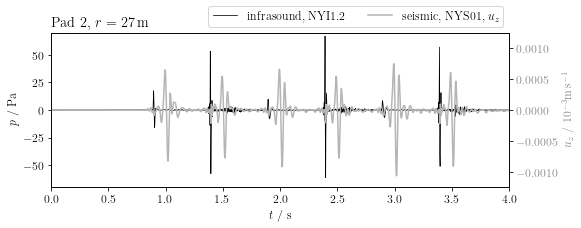

In [60]:
fig, axi = plt.subplots()
axs = axi.twinx()

stl = {
    'z': {'color': '#b5b5b5', 'ls': 'solid', 'lw': 1.5},
    'i': {'color': '#000000', 'ls': 'solid', 'lw': 0.75}
}

start, end = 0, 4
start, end = int(srate * (start + toff)), int((end + toff) * srate)
t = ssin['t'][:] - toff
axi.plot(t[start:end], highpass(ssin['inf'][1][2][start:end], .05),
         **stl['i'], zorder=1)
axs.plot([], [], **stl['i'], label='infrasound, NYI1.2')
axs.plot(t[start:end], highpass(ssin['seis'][1]['hhz'][start:end], .05),
         **stl['z'], zorder=2, label='seismic, NYS01, $u_z$')
axi.set_ylim(-70, 70)
axs.set_ylim(-1.25e-3, 1.25e-3)
axs.set_xlim(0, 4)

[lbl.set_color(stl['i']['color']) for lbl in axi.get_yticklabels()]
[lbl.set_color('#858585') for lbl in axs.get_yticklabels()]

axi.set_ylabel(r'$p\ /\ \mathrm{Pa}$', color='k')
axs.set_ylabel(r'$u_z\ /\ \mathrm{10^{-3}m\,s^{-1}}$', color='#858585')
axi.set_xlabel(r'$t\ /\ \mathrm{s}$')

axs.set_title(r'Pad 2, $r=27\,\mathrm{m}$', loc='left')
axs.legend(loc='lower right', bbox_to_anchor=(1, 1), ncol=2)

fig.subplots_adjust(top=0.865, bottom=0.15, left=0.085, right=0.88)
fig.set_size_inches(8, 3)
# fig

### Pad 3

In [61]:
ssin = af['pad3']

In [62]:
byu_ch['rline']['h']

array([ 7, 22, 17, 19, 21, 25, 27, 29])

In [63]:
byu_ch['rline']['l']

array([ 6, 15, 14, 16, 18, 20, 24, 26, 28])

TODO: Not sure what's up with BYU channel 21, for this pad, but the r-column seems invalid...

Text(0.5, 0.98, 'Pad 3')

posx and posy should be finite values
posx and posy should be finite values


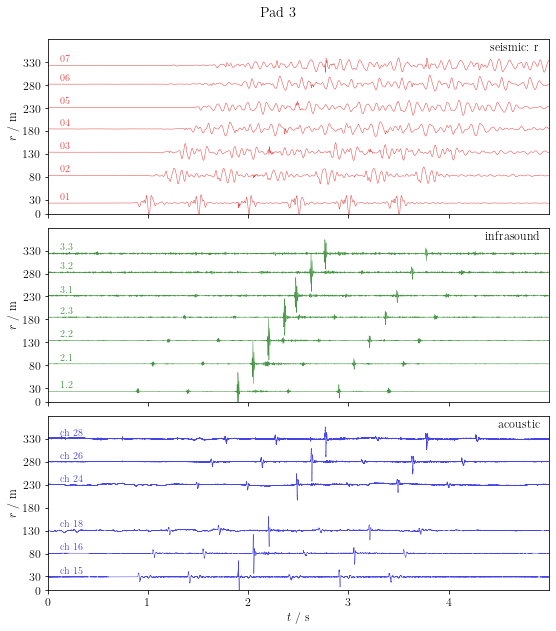

In [64]:
fig, axs = plot01(ssin, byu_mics['pad3'], 0., 5., pad=3, vel='n',
                  prch=ich, mch=[15, 16, 18, 21, 24, 26, 28], showch=True)
fig.suptitle("Pad 3")
# fig

### Pad 4

In [65]:
ssin = af['pad4']

In [66]:
byu_ch['rline']['h']

array([ 7, 22, 17, 19, 21, 25, 27, 29])

In [67]:
byu_ch['rline']['l']

array([ 6, 15, 14, 16, 18, 20, 24, 26, 28])

Text(0.5, 0.98, 'Pad 4')

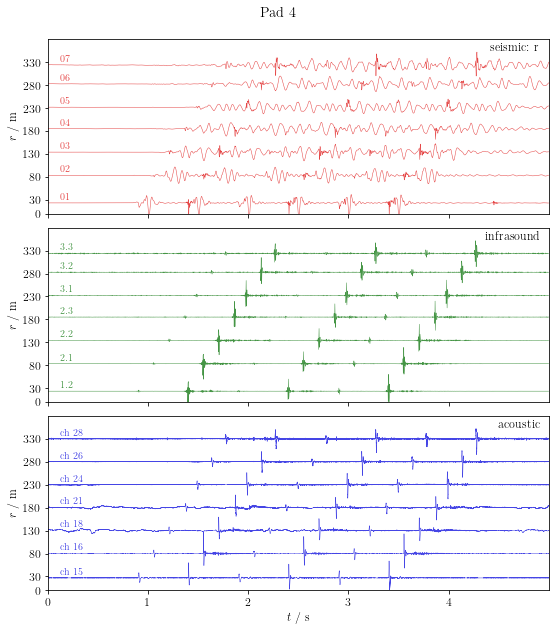

In [68]:
fig, axs = plot01(ssin, byu_mics['pad4'], 0., 5., pad=4, vel='n',
                  prch=ich, mch=[15, 16, 18, 21, 24, 26, 28], showch=True)
fig.suptitle("Pad 4")
# fig

In [69]:
summ = af['summ'] = {'seis': {}, 'inf': {}}

In [70]:
summ['seis'] = {
    'columns': list(ssumm.columns),
    'values': ssumm.values
}
summ['inf'] = {
    'columns': list(isumm.columns),
    'values': isumm.values
}